### Grid Searching Decision Trees

This try-it focuses on performing a grid search with a `DecisionTreeClassifier`.  As mentioned in the lectures, the grid search for a tree model can get large very easily. In addition to using `GridSearchCV`, scikitlearn implements additional tools that can save energy and offer alternatives to the brute force exhaustive search.  Below, you will compare the performance of some of these alternatives and discuss the time these searches take.  Note that this will be in large part determined by your personal computing power however the relative speed of the searches should be consistent.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_halving_search_cv
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV
import time

In [35]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 3, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 10]
}

In [37]:
model = DecisionTreeClassifier()

### Comparing Grid Searches

Below, explore the four grid search options using the same parameter selections for the `DecisionTreeClassifier`. All of the grid searching tools have a `.cv_results_` attribute after fitting that contains information after fitting including time.  Use this to compare the time of each search and discuss what you believe the "best" approach to identifying the hyperparameters of the model are between:

- `GridSearchCV`
- `RandomizedSearchCV`
- `HalvingGridSearchCV`
- `HalvingRandomSearchCV`

Share your results in a plot comparing the different times for searching across the different parameters as well as the score of the different estimators that resulted from the grid search.  

In [40]:
data = pd.read_csv('./data/Whickham.txt')
data

,outcome,smoker,age
0,Alive,Yes,23
1,Alive,Yes,18
2,Dead,Yes,71
3,Alive,No,67
4,Alive,No,64
...,...,...,...
1309,Alive,Yes,35
1310,Alive,No,33
1311,Alive,Yes,21
1312,Alive,No,46


In [42]:
# Preprocessing
# Convert 'outcome' to binary labels (Alive = 1, Dead = 0)
data['outcome'] = data['outcome'].map({'Alive': 1, 'Dead': 0})

# Encode the 'smoker' column to binary (Yes = 1, No = 0)
data['smoker'] = data['smoker'].map({'Yes': 1, 'No': 0})

# Define features and target
X = data[['age', 'smoker']]
y = data['outcome']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
# Function to time the grid search and return the results
def run_search(search_method, param_grid, X_train, y_train):
    start_time = time.time()
    search_method.fit(X_train, y_train)
    end_time = time.time()
    
    best_estimator = search_method.best_estimator_
    best_score = search_method.best_score_
    search_time = end_time - start_time
    return search_time, best_estimator, best_score

In [46]:
# Perform GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, verbose=1)
grid_time, grid_estimator, grid_score = run_search(grid_search, param_grid, X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [48]:
# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, cv=5, verbose=1)
random_time, random_estimator, random_score = run_search(random_search, param_grid, X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [50]:
# Perform HalvingGridSearchCV
halving_grid_search = HalvingGridSearchCV(model, param_grid, cv=5, verbose=1)
halving_grid_time, halving_grid_estimator, halving_grid_score = run_search(halving_grid_search, param_grid, X_train, y_train)

n_iterations: 4
n_required_iterations: 5
n_possible_iterations: 4
min_resources_: 20
max_resources_: 1051
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 144
n_resources: 20
Fitting 5 folds for each of 144 candidates, totalling 720 fits
----------
iter: 1
n_candidates: 48
n_resources: 60
Fitting 5 folds for each of 48 candidates, totalling 240 fits
----------
iter: 2
n_candidates: 16
n_resources: 180
Fitting 5 folds for each of 16 candidates, totalling 80 fits
----------
iter: 3
n_candidates: 6
n_resources: 540
Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [54]:
# Perform HalvingRandomSearchCV
halving_random_search = HalvingRandomSearchCV(model, param_distributions=param_grid, cv=5, verbose=1)
halving_random_time, halving_random_estimator, halving_random_score = run_search(halving_random_search, param_grid, X_train, y_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 20
max_resources_: 1051
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 52
n_resources: 20
Fitting 5 folds for each of 52 candidates, totalling 260 fits
----------
iter: 1
n_candidates: 18
n_resources: 60
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 2
n_candidates: 6
n_resources: 180
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 3
n_candidates: 2
n_resources: 540
Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [56]:
# Create a DataFrame for the results
results = pd.DataFrame({
    'Search Method': ['GridSearchCV', 'RandomizedSearchCV', 'HalvingGridSearchCV', 'HalvingRandomSearchCV'],
    'Time (s)': [grid_time, random_time, halving_grid_time, halving_random_time],
    'Best Score': [grid_score, random_score, halving_grid_score, halving_random_score]
})

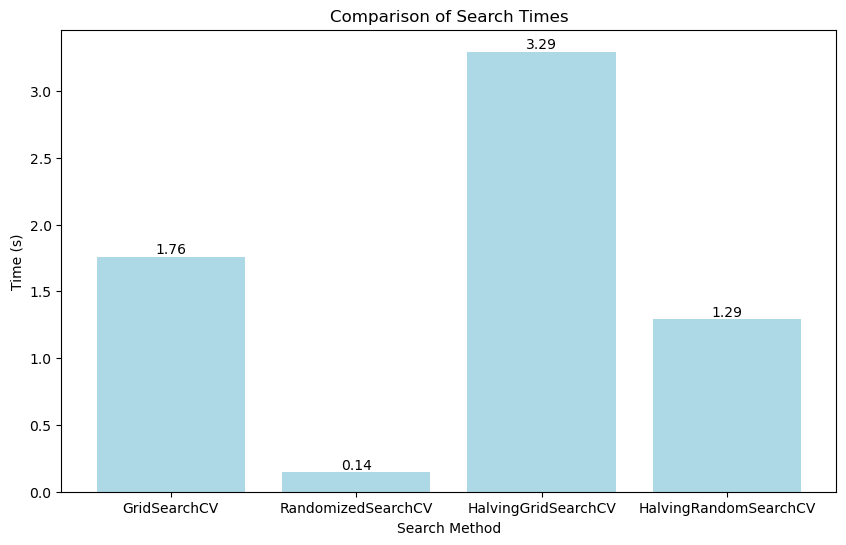

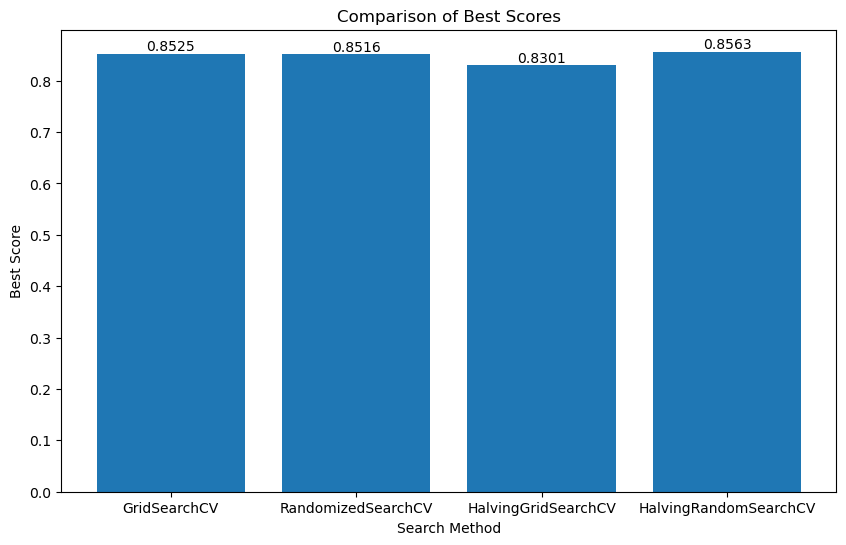

In [64]:
# Plot the results
plt.figure(figsize=(10,6))
bars = plt.bar(results['Search Method'], results['Time (s)'], color='lightblue')

# Add the time on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.title('Comparison of Search Times')
plt.xlabel('Search Method')
plt.ylabel('Time (s)')
plt.show()

plt.figure(figsize=(10,6))
bars = plt.bar(results['Search Method'], results['Best Score'])

# Add the score on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

plt.title('Comparison of Best Scores')
plt.xlabel('Search Method')
plt.ylabel('Best Score')
plt.show()